In [1]:
from __future__ import division
import tensorflow as tf
from tensorflow.contrib.rnn import GRUCell, MultiRNNCell,BasicLSTMCell
import os
from utils import shape
import numpy as np
import shutil
#from config import TrainConfig
import matplotlib.pyplot as plt
import librosa.display
import random
from os import walk
import math
# -*- coding: utf-8 -*-
#!/usr/bin/env python

import tensorflow as tf
from utils import closest_power_of_two

# TODO tf arg
# Model
class ModelConfig:
    SR = 16000                # Sample Rate
    L_FRAME = 1024            # default 1024
    L_HOP = closest_power_of_two(L_FRAME / 4)
    SEQ_LEN = 4
    # For Melspectogram
    N_MELS = 512
    F_MIN = 0.0

# Train
class TrainConfig:
    CASE = str(ModelConfig.SEQ_LEN) + 'frames_ikala'
    CKPT_PATH = 'checkpoints/' + CASE
    GRAPH_PATH = 'graphs/' + CASE + '/train'
    DATA_PATH = 'dataset/train/ikala'
    DATA_PATH2 = 'dataset/test/ikala'
    LR = 0.0001
    FINAL_STEP = 1000#00#00
    CKPT_STEP = 50#0
    NUM_WAVFILE = 1
    SECONDS = 8.192 # To get 512,512 in melspecto
    RE_TRAIN = True
    session_conf = tf.ConfigProto(
        device_count={'CPU': 1, 'GPU': 1},
        gpu_options=tf.GPUOptions(
            allow_growth=True,
            per_process_gpu_memory_fraction=0.25
        ),
    )
#Test
# Train
    
    
#haha = np.loadtxt(open('errorrate.csv',"rb"),delimiter=",",skiprows=0)[0,:]
#plt.plot(haha)

In [2]:
#preprocess
def get_random_wav(filenames, sec, sr=ModelConfig.SR):
    # load wav -> pad if necessary to fit sr*sec -> get random samples with len = sr*sec -> map = do this for all in filenames -> put in np.array
    src1_src2 = np.array(list(map(lambda f: _sample_range(_pad_wav(librosa.load(f, sr=sr, mono=False)[0], sr, sec), sr, sec), filenames)))
    mixed = np.array(list(map(lambda f: librosa.to_mono(f), src1_src2)))
    src1, src2 = src1_src2[:, 0], src1_src2[:, 1]
    return mixed, src1, src2

# Batch considered
def to_spectrogram(wav, len_frame=ModelConfig.L_FRAME, len_hop=ModelConfig.L_HOP):
    return np.array(list(map(lambda w: librosa.stft(w, n_fft=len_frame, hop_length=len_hop), wav)))
    #逆变换：istft(stft_matrixes)
# Batch considered
def to_wav(mag, phase, len_hop=ModelConfig.L_HOP):
    stft_matrix = get_stft_matrix(mag, phase)
    return np.array(list(map(lambda s: librosa.istft(s, hop_length=len_hop), stft_matrix)))

# Batch considered
def to_wav_from_spec(stft_maxrix, len_hop=ModelConfig.L_HOP):
    return np.array(list(map(lambda s: librosa.istft(s, hop_length=len_hop), stft_maxrix)))

# Batch considered
def to_wav_mag_only(mag, init_phase, len_frame=ModelConfig.L_FRAME, len_hop=ModelConfig.L_HOP, num_iters=50):
    #return np.array(list(map(lambda m_p: griffin_lim(m, len_frame, len_hop, num_iters=num_iters, phase_angle=p)[0], list(zip(mag, init_phase))[1])))
    return np.array(list(map(lambda m: lambda p: griffin_lim(m, len_frame, len_hop, num_iters=num_iters, phase_angle=p), list(zip(mag, init_phase))[1])))

# Batch considered
def get_magnitude(stft_matrixes):
    return np.abs(stft_matrixes)

# Batch considered
def get_phase(stft_maxtrixes):
    return np.angle(stft_maxtrixes)

# Batch considered
def get_stft_matrix(magnitudes, phases):
    return magnitudes * np.exp(1.j * phases)

# Batch considered
def soft_time_freq_mask(target_src, remaining_src):
    mask = np.abs(target_src) / (np.abs(target_src) + np.abs(remaining_src) + np.finfo(float).eps)
    return mask

# Batch considered
def hard_time_freq_mask(target_src, remaining_src):
    mask = np.where(target_src > remaining_src, 1., 0.)
    return mask

def write_wav(data, path, sr=ModelConfig.SR, format='wav', subtype='PCM_16'):
    sf.write('{}.wav'.format(path), data, sr, format=format, subtype=subtype)

def griffin_lim(mag, len_frame, len_hop, num_iters, phase_angle=None, length=None):
    assert(num_iters > 0)
    if phase_angle is None:
        phase_angle = np.pi * np.random.rand(*mag.shape)
    spec = get_stft_matrix(mag, phase_angle)
    for i in range(num_iters):
        wav = librosa.istft(spec, win_length=len_frame, hop_length=len_hop, length=length)
        if i != num_iters - 1:
            spec = librosa.stft(wav, n_fft=len_frame, win_length=len_frame, hop_length=len_hop)
            _, phase = librosa.magphase(spec)
            phase_angle = np.angle(phase)
            spec = get_stft_matrix(mag, phase_angle)
    return wav

def _pad_wav(wav, sr, duration):
    assert(wav.ndim <= 2)

    n_samples = int(sr * duration)
    pad_len = np.maximum(0, n_samples - wav.shape[-1])
    if wav.ndim == 1:
        pad_width = (0, pad_len)
    else:
        pad_width = ((0, 0), (0, pad_len))
    wav = np.pad(wav, pad_width=pad_width, mode='constant', constant_values=0)

    return wav

def _sample_range(wav, sr, duration):
    assert(wav.ndim <= 2)

    target_len = int(sr * duration)
    wav_len = wav.shape[-1]
    start = np.random.choice(range(np.maximum(1, wav_len - target_len)), 1)[0]
    end = start + target_len
    if wav.ndim == 1:
        wav = wav[start:end]
    else:
        wav = wav[:, start:end]
    return wav
def bss_eval_sources(reference_sources, estimated_sources,
                     compute_permutation=True):

    # make sure the input is of shape (nsrc, nsampl)
    if estimated_sources.ndim == 1:
        estimated_sources = estimated_sources[np.newaxis, :]
        print("estimated_sources.ndim == 1")
    if reference_sources.ndim == 1:
        reference_sources = reference_sources[np.newaxis, :]
        print("reference_sources.ndim == 1")

    validate(reference_sources, estimated_sources)
    # If empty matrices were supplied, return empty lists (special case)
    if reference_sources.size == 0 or estimated_sources.size == 0:
        return np.array([]), np.array([]), np.array([]), np.array([])

    nsrc = estimated_sources.shape[0]

    # does user desire permutations?
    if compute_permutation:
        # compute criteria for all possible pair matches
        sdr = np.empty((nsrc, nsrc))
        sir = np.empty((nsrc, nsrc))
        sar = np.empty((nsrc, nsrc))
        for jest in range(nsrc):
            for jtrue in range(nsrc):
                s_true, e_spat, e_interf, e_artif = \
                    _bss_decomp_mtifilt(reference_sources,
                                        estimated_sources[jest],
                                        jtrue, 512)
                sdr[jest, jtrue], sir[jest, jtrue], sar[jest, jtrue] = \
                    _bss_source_crit(s_true, e_spat, e_interf, e_artif)

        # select the best ordering
        perms = list(itertools.permutations(list(range(nsrc))))
        mean_sir = np.empty(len(perms))
        dum = np.arange(nsrc)
        for (i, perm) in enumerate(perms):
            mean_sir[i] = np.mean(sir[perm, dum])
        popt = perms[np.argmax(mean_sir)]
        idx = (popt, dum)
        return (sdr[idx], sir[idx], sar[idx], np.asarray(popt))
    else:
        # compute criteria for only the simple correspondence
        # (estimate 1 is estimate corresponding to reference source 1, etc.)
        sdr = np.empty(nsrc)
        sir = np.empty(nsrc)
        sar = np.empty(nsrc)
        for j in range(nsrc):
            s_true, e_spat, e_interf, e_artif = \
                _bss_decomp_mtifilt(reference_sources,
                                    estimated_sources[j],
                                    j, 512)
            sdr[j], sir[j], sar[j] = \
                _bss_source_crit(s_true, e_spat, e_interf, e_artif)

        # return the default permutation for compatibility
        popt = np.arange(nsrc)
        return (sdr, sir, sar, popt)
#preprocess
def get_random_wav(filenames, sec, sr=22050):
    # load wav -> pad if necessary to fit sr*sec -> get random samples with len = sr*sec -> map = do this for all in filenames -> put in np.array
    src1_src2 = np.array(list(map(lambda f: _sample_range(_pad_wav(librosa.load(f, sr=sr, mono=False)[0], sr, sec), sr, sec), filenames)))
    mixed = np.array(list(map(lambda f: librosa.to_mono(f), src1_src2)))   #用librosa转换成单一
    src1, src2 = src1_src2[:, 0], src1_src2[:, 1]
    return mixed, src1, src2
wavfiles = []
for (root, dirs, files) in walk('dataset/train/ikala'):
    wavfiles.extend(['{}/{}'.format(root, f) for f in files if f.endswith(".wav")])
    wavfiles = random.sample(wavfiles, 1)
    print(wavfiles);
    mixed, src1, src2 = get_random_wav(wavfiles, 8.192, ModelConfig.SR)
mixed = np.squeeze(mixed)
print(type(mixed));
print(mixed.T.shape)
print(mixed.T.reshape(mixed.T.shape))


def bss_eval_global(mixed_wav, src1_wav, src2_wav, pred_src1_wav, pred_src2_wav):
    len_cropped = pred_src1_wav.shape[-1]
    src1_wav = src1_wav[:, :len_cropped]
    src2_wav = src2_wav[:, :len_cropped]
    mixed_wav = mixed_wav[:, :len_cropped]
    gnsdr = gsir = gsar = np.zeros(2)
    total_len = 0
    for i in range(1,1):
        sdr, sir, sar, _ = bss_eval_sources(np.array([src1_wav[i], src2_wav[i]]),
                                            np.array([pred_src1_wav[i], pred_src2_wav[i]]), False)
        sdr_mixed, _, _, _ = bss_eval_sources(np.array([src1_wav[i], src2_wav[i]]),
                                              np.array([mixed_wav[i], mixed_wav[i]]), False)
        nsdr = sdr - sdr_mixed
        gnsdr += len_cropped * nsdr
        gsir += len_cropped * sir
        gsar += len_cropped * sar
        total_len += len_cropped
    gnsdr = gnsdr / total_len
    gsir = gsir / total_len
    gsar = gsar / total_len
    return gnsdr, gsir, gsar

def to_spectrogram(wav, len_frame=1024, len_hop=closest_power_of_two(1024/4)):
    return np.array(list(map(lambda w: librosa.stft(w, n_fft=len_frame, hop_length=len_hop), wav)))
print(closest_power_of_two(1024/4));

['dataset/train/ikala/geniusturtle_2_01.wav']
<class 'numpy.ndarray'>
(131072,)
[ 0.02972412  0.02215576  0.04653931 ... -0.02876282  0.072052
  0.0491333 ]
256


In [3]:

class Model:
    def __init__(self, n_rnn_layer=3, hidden_size=256):
        print('Model initializing')
        print(ModelConfig.L_FRAME // 2 + 1);
        # Input, Output
        self.x_mixed = tf.placeholder(tf.float32, shape=(None, None, ModelConfig.L_FRAME // 2 + 1), name='x_mixed')
        self.y_src1 = tf.placeholder(tf.float32, shape=(None, None, ModelConfig.L_FRAME // 2 + 1), name='y_src1')
        self.y_src2 = tf.placeholder(tf.float32, shape=(None, None, ModelConfig.L_FRAME // 2 + 1), name='y_src2')

        # 隐藏层神经元
        self.hidden_size = hidden_size
        #几层神经网络
        self.n_layer = n_rnn_layer
        self.net = tf.make_template('net', self._net)
        self()

    def __call__(self):
        return self.net()
    

    def _net(self):
        # RNN and dense layers
        rnn_layer = MultiRNNCell([GRUCell(self.hidden_size) for _ in range(self.n_layer)])
        output_rnn, rnn_state = tf.nn.dynamic_rnn(rnn_layer, self.x_mixed, dtype=tf.float32)
        input_size = shape(self.x_mixed)[2]
        y_hat_src1 = tf.layers.dense(inputs=output_rnn, units=input_size, activation=tf.nn.relu, name='y_hat_src1')
        y_hat_src2 = tf.layers.dense(inputs=output_rnn, units=input_size, activation=tf.nn.relu, name='y_hat_src2')

        # time-freq masking layer
        y_tilde_src1 = y_hat_src1 / (y_hat_src1 + y_hat_src2 + np.finfo(float).eps) * self.x_mixed
        y_tilde_src2 = y_hat_src2 / (y_hat_src1 + y_hat_src2 + np.finfo(float).eps) * self.x_mixed

        return y_tilde_src1, y_tilde_src2

    def loss(self):
        pred_y_src1, pred_y_src2 = self()
        return tf.square(self.y_src1 - pred_y_src1) + tf.square(self.y_src2 - pred_y_src2) # tf.reduce_mean(, name='loss')

    @staticmethod
    # shape = (batch_size, n_freq, n_frames) => (batch_size, n_frames, n_freq)
    def spec_to_batch(src):
        num_wavs, freq, n_frames = src.shape

        # Padding
        pad_len = 0
        if n_frames % ModelConfig.SEQ_LEN > 0:
            pad_len = (ModelConfig.SEQ_LEN - (n_frames % ModelConfig.SEQ_LEN))
        pad_width = ((0, 0), (0, 0), (0, pad_len))
        padded_src = np.pad(src, pad_width=pad_width, mode='constant', constant_values=0)

        assert(padded_src.shape[-1] % ModelConfig.SEQ_LEN == 0)

        batch = np.reshape(padded_src.transpose(0, 2, 1), (-1, ModelConfig.SEQ_LEN, freq))#-1是让函数自己计算
        return batch, padded_src

    @staticmethod
    def batch_to_spec(src, num_wav):
        # shape = (batch_size, n_frames, n_freq) => (batch_size, n_freq, n_frames)
        batch_size, seq_len, freq = src.shape
        src = np.reshape(src, (num_wav, -1, freq))
        src = src.transpose(0, 2, 1)
        return src

    @staticmethod
    def load_state(sess, ckpt_path):
        ckpt = tf.train.get_checkpoint_state(os.path.dirname(ckpt_path + '/checkpoint'))
        if ckpt and ckpt.model_checkpoint_path:
            tf.train.Saver().restore(sess, ckpt.model_checkpoint_path)

In [4]:
# -*- coding: utf-8 -*-
# !/usr/bin/env python
'''
By Dabi Ahn. andabi412@gmail.com.
https://www.github.com/andabi
'''



class Data:
    def __init__(self, path):
        self.path = path

    def next_wavs(self, sec, size=1):
        wavfiles = []
        for (root, dirs, files) in walk(self.path):
            wavfiles.extend(['{}/{}'.format(root, f) for f in files if f.endswith(".wav")])
        wavfiles = random.sample(wavfiles, size)
        mixed, src1, src2 = get_random_wav(wavfiles, sec, ModelConfig.SR)
        return mixed, src1, src2, wavfiles

class Data:
    def __init__(self, path):
        self.path = path

    def next_wavs(self, sec, size=1):
        wavfiles = []
        for (root, dirs, files) in walk(self.path):
            wavfiles.extend(['{}/{}'.format(root, f) for f in files if f.endswith(".wav")])
        wavfiles = random.sample(wavfiles, size)
        mixed, src1, src2 = get_random_wav(wavfiles, sec, ModelConfig.SR)
        return mixed, src1, src2, wavfiles
    
def get_random_wav(filenames, sec, sr=ModelConfig.SR):
    # load wav -> pad if necessary to fit sr*sec -> get random samples with len = sr*sec -> map = do this for all in filenames -> put in np.array
    src1_src2 = np.array(list(map(lambda f: _sample_range(_pad_wav(librosa.load(f, sr=sr, mono=False)[0], sr, sec), sr, sec), filenames)))
    print('loaded wave');
    print(src1_src2.shape)
    mixed = np.array(list(map(lambda f: librosa.to_mono(f), src1_src2)))
    src1, src2 = src1_src2[:, 0], src1_src2[:, 1]
    return mixed, src1, src2

class Diff(object):
    def __init__(self, v=0.):
        self.value = v
        self.diff = 0.

    def update(self, v):
        if self.value:
            diff = (v / self.value - 1)
            self.diff = diff
        self.value = v


<tf.Variable 'net/rnn/multi_rnn_cell/cell_0/gru_cell/gates/kernel:0' shape=(769, 512) dtype=float32_ref>
Tensor("loss:0", shape=(), dtype=float32)
INFO:tensorflow:Summary name net/rnn/multi_rnn_cell/cell_0/gru_cell/gates/kernel:0 is illegal; using net/rnn/multi_rnn_cell/cell_0/gru_cell/gates/kernel_0 instead.
INFO:tensorflow:Summary name grad/net/rnn/multi_rnn_cell/cell_0/gru_cell/gates/kernel:0 is illegal; using grad/net/rnn/multi_rnn_cell/cell_0/gru_cell/gates/kernel_0 instead.
<tf.Variable 'net/rnn/multi_rnn_cell/cell_0/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
Tensor("loss:0", shape=(), dtype=float32)
INFO:tensorflow:Summary name net/rnn/multi_rnn_cell/cell_0/gru_cell/gates/bias:0 is illegal; using net/rnn/multi_rnn_cell/cell_0/gru_cell/gates/bias_0 instead.
INFO:tensorflow:Summary name grad/net/rnn/multi_rnn_cell/cell_0/gru_cell/gates/bias:0 is illegal; using grad/net/rnn/multi_rnn_cell/cell_0/gru_cell/gates/bias_0 instead.
<tf.Variable 'net/rnn/multi_rnn_cell/cell_0/

step-17	d_loss=-27.27	loss=6.7467851638793945
6.7467851638793945
step-18	d_loss=38.16	loss=9.321610450744629
9.321610450744629
step-19	d_loss=-17.51	loss=7.689549446105957
7.689549446105957
step-20	d_loss=6.82	loss=8.213801383972168
8.213801383972168
step-21	d_loss=-2.44	loss=8.013689041137695
8.013689041137695
step-22	d_loss=20.99	loss=9.695801734924316
9.695801734924316
step-23	d_loss=-4.98	loss=9.212531089782715
9.212531089782715
step-24	d_loss=-10.05	loss=8.286933898925781
8.286933898925781
step-25	d_loss=14.97	loss=9.527524948120117
9.527524948120117
step-26	d_loss=-23.98	loss=7.2425994873046875
7.2425994873046875
step-27	d_loss=1.10	loss=7.322343826293945
7.322343826293945
step-28	d_loss=-18.15	loss=5.993375301361084
5.993375301361084
step-29	d_loss=15.60	loss=6.928400993347168
6.928400993347168
step-30	d_loss=13.94	loss=7.8945231437683105
7.8945231437683105
step-31	d_loss=6.06	loss=8.372650146484375
8.372650146484375
step-32	d_loss=-10.26	loss=7.513962745666504
7.513962745666504

step-149	d_loss=10.50	loss=6.504024028778076
6.504024028778076
step-150	d_loss=13.38	loss=7.373948574066162
7.373948574066162
step-151	d_loss=-1.63	loss=7.253920555114746
7.253920555114746
step-152	d_loss=19.53	loss=8.670418739318848
8.670418739318848
step-153	d_loss=-18.16	loss=7.095567226409912
7.095567226409912
step-154	d_loss=-11.01	loss=6.314639091491699
6.314639091491699
step-155	d_loss=12.75	loss=7.119624614715576
7.119624614715576
step-156	d_loss=-0.06	loss=7.115662574768066
7.115662574768066
step-157	d_loss=-1.96	loss=6.975845813751221
6.975845813751221
step-158	d_loss=7.04	loss=7.467020034790039
7.467020034790039
step-159	d_loss=-9.81	loss=6.734640598297119
6.734640598297119
step-160	d_loss=-1.08	loss=6.661734580993652
6.661734580993652
step-161	d_loss=17.12	loss=7.802309513092041
7.802309513092041
step-162	d_loss=-16.28	loss=6.532022476196289
6.532022476196289
step-163	d_loss=10.01	loss=7.185813903808594
7.185813903808594
step-164	d_loss=-3.75	loss=6.916278839111328
6.916278

step-280	d_loss=6.99	loss=6.957030296325684
6.957030296325684
step-281	d_loss=-3.10	loss=6.741507053375244
6.741507053375244
step-282	d_loss=-3.03	loss=6.537036418914795
6.537036418914795
step-283	d_loss=-8.18	loss=6.002416133880615
6.002416133880615
step-284	d_loss=14.90	loss=6.896652698516846
6.896652698516846
step-285	d_loss=-16.69	loss=5.745475769042969
5.745475769042969
step-286	d_loss=34.40	loss=7.721904277801514
7.721904277801514
step-287	d_loss=-14.69	loss=6.587305068969727
6.587305068969727
step-288	d_loss=-7.08	loss=6.121113300323486
6.121113300323486
step-289	d_loss=16.76	loss=7.146996021270752
7.146996021270752
step-290	d_loss=-5.98	loss=6.719627857208252
6.719627857208252
step-291	d_loss=-10.39	loss=6.021463871002197
6.021463871002197
step-292	d_loss=12.78	loss=6.790771484375
6.790771484375
step-293	d_loss=-20.82	loss=5.376826763153076
5.376826763153076
step-294	d_loss=46.09	loss=7.855195045471191
7.855195045471191
step-295	d_loss=-8.74	loss=7.168667316436768
7.16866731643

step-411	d_loss=-4.45	loss=6.260734558105469
6.260734558105469
step-412	d_loss=-10.65	loss=5.59373664855957
5.59373664855957
step-413	d_loss=28.83	loss=7.206284523010254
7.206284523010254
step-414	d_loss=-12.14	loss=6.331620693206787
6.331620693206787
step-415	d_loss=-4.42	loss=6.051642417907715
6.051642417907715
step-416	d_loss=4.74	loss=6.338561534881592
6.338561534881592
step-417	d_loss=12.30	loss=7.118368148803711
7.118368148803711
step-418	d_loss=-18.04	loss=5.834438800811768
5.834438800811768
step-419	d_loss=13.40	loss=6.6160359382629395
6.6160359382629395
step-420	d_loss=6.43	loss=7.041494846343994
7.041494846343994
step-421	d_loss=-25.04	loss=5.278069972991943
5.278069972991943
step-422	d_loss=24.71	loss=6.582047939300537
6.582047939300537
step-423	d_loss=7.32	loss=7.063691139221191
7.063691139221191
step-424	d_loss=-14.60	loss=6.032296657562256
6.032296657562256
step-425	d_loss=-0.32	loss=6.01324987411499
6.01324987411499
step-426	d_loss=-1.17	loss=5.942871570587158
5.94287157

step-542	d_loss=20.12	loss=6.333768367767334
6.333768367767334
step-543	d_loss=11.64	loss=7.071335315704346
7.071335315704346
step-544	d_loss=-9.22	loss=6.419243812561035
6.419243812561035
step-545	d_loss=-17.48	loss=5.296934604644775
5.296934604644775
step-546	d_loss=34.59	loss=7.1291656494140625
7.1291656494140625
step-547	d_loss=-18.12	loss=5.837228298187256
5.837228298187256
step-548	d_loss=9.70	loss=6.403653621673584
6.403653621673584
step-549	d_loss=10.27	loss=7.061207294464111
7.061207294464111
step-550	d_loss=-5.72	loss=6.657527446746826
6.657527446746826
step-551	d_loss=-6.83	loss=6.20248556137085
6.20248556137085
step-552	d_loss=9.18	loss=6.771687984466553
6.771687984466553
step-553	d_loss=-7.12	loss=6.2894697189331055
6.2894697189331055
step-554	d_loss=-12.21	loss=5.521603584289551
5.521603584289551
step-555	d_loss=10.15	loss=6.081873416900635
6.081873416900635
step-556	d_loss=19.63	loss=7.275820732116699
7.275820732116699
step-557	d_loss=-4.03	loss=6.98229455947876
6.982294

step-672	d_loss=-27.46	loss=5.488972187042236
5.488972187042236
step-673	d_loss=20.38	loss=6.607665061950684
6.607665061950684
step-674	d_loss=-17.20	loss=5.471299171447754
5.471299171447754
step-675	d_loss=3.64	loss=5.670713424682617
5.670713424682617
step-676	d_loss=-1.93	loss=5.561387062072754
5.561387062072754
step-677	d_loss=12.56	loss=6.260008811950684
6.260008811950684
step-678	d_loss=4.87	loss=6.565040588378906
6.565040588378906
step-679	d_loss=-9.94	loss=5.912422180175781
5.912422180175781
step-680	d_loss=-1.41	loss=5.829200267791748
5.829200267791748
step-681	d_loss=10.41	loss=6.436178684234619
6.436178684234619
step-682	d_loss=8.62	loss=6.991273403167725
6.991273403167725
step-683	d_loss=-16.93	loss=5.8075456619262695
5.8075456619262695
step-684	d_loss=11.89	loss=6.497824192047119
6.497824192047119
step-685	d_loss=13.31	loss=7.362810134887695
7.362810134887695
step-686	d_loss=-20.03	loss=5.888082027435303
5.888082027435303
step-687	d_loss=-10.63	loss=5.262431621551514
5.2624

step-802	d_loss=-12.31	loss=5.942420959472656
5.942420959472656
step-803	d_loss=18.00	loss=7.012343406677246
7.012343406677246
step-804	d_loss=-0.22	loss=6.997243881225586
6.997243881225586
step-805	d_loss=-28.74	loss=4.986137390136719
4.986137390136719
step-806	d_loss=1.04	loss=5.037849426269531
5.037849426269531
step-807	d_loss=11.11	loss=5.597557544708252
5.597557544708252
step-808	d_loss=8.98	loss=6.100142478942871
6.100142478942871
step-809	d_loss=-0.06	loss=6.096541404724121
6.096541404724121
step-810	d_loss=-17.37	loss=5.037712574005127
5.037712574005127
step-811	d_loss=14.51	loss=5.768743515014648
5.768743515014648
step-812	d_loss=-0.40	loss=5.74569845199585
5.74569845199585
step-813	d_loss=-0.24	loss=5.731966018676758
5.731966018676758
step-814	d_loss=7.71	loss=6.174041271209717
6.174041271209717
step-815	d_loss=-7.22	loss=5.728142738342285
5.728142738342285
step-816	d_loss=19.69	loss=6.856071472167969
6.856071472167969
step-817	d_loss=1.35	loss=6.948598384857178
6.94859838485

step-933	d_loss=18.20	loss=6.303723335266113
6.303723335266113
step-934	d_loss=8.84	loss=6.861039161682129
6.861039161682129
step-935	d_loss=-15.12	loss=5.823613166809082
5.823613166809082
step-936	d_loss=8.80	loss=6.3358988761901855
6.3358988761901855
step-937	d_loss=-13.64	loss=5.471880912780762
5.471880912780762
step-938	d_loss=10.48	loss=6.045565605163574
6.045565605163574
step-939	d_loss=8.18	loss=6.539990425109863
6.539990425109863
step-940	d_loss=-3.43	loss=6.315445423126221
6.315445423126221
step-941	d_loss=5.07	loss=6.6356892585754395
6.6356892585754395
step-942	d_loss=-17.77	loss=5.4564080238342285
5.4564080238342285
step-943	d_loss=34.93	loss=7.362270832061768
7.362270832061768
step-944	d_loss=4.42	loss=7.687535762786865
7.687535762786865
step-945	d_loss=-33.64	loss=5.101168632507324
5.101168632507324
step-946	d_loss=15.67	loss=5.900710105895996
5.900710105895996
step-947	d_loss=27.74	loss=7.537725925445557
7.537725925445557
step-948	d_loss=-21.91	loss=5.886439323425293
5.88

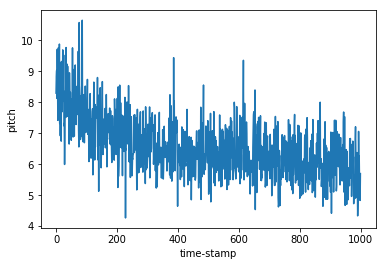

predicted accompany:


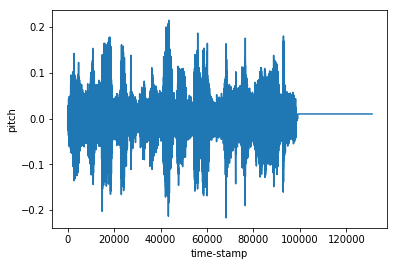

predicted vocal:


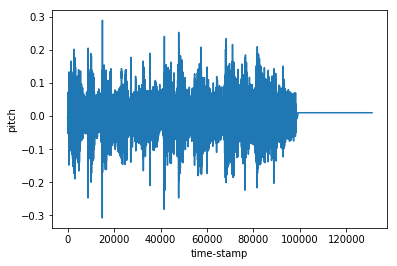

original accompany:


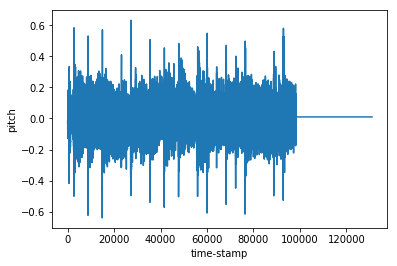

original vocal:


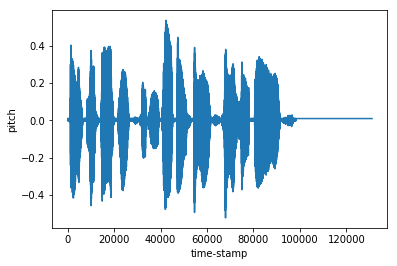

(1, 131072)
Difference:


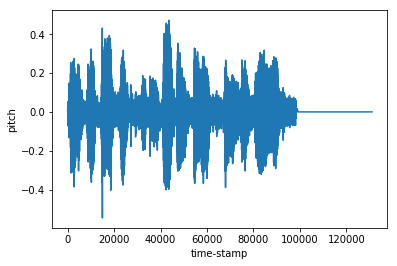

0.9155975


In [5]:
import tensorflow as tf
#from model import Model
from model import Model
import os
import shutil
from data import Data
from preprocess import to_spectrogram, get_magnitude

import librosa.display


def summaries(model, loss):
    for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES):
        print(v);
        print(loss);
        tf.summary.histogram(v.name, v)
        tf.summary.histogram('grad/' + v.name, tf.gradients(loss, v))
    tf.summary.scalar('loss', loss)
    tf.summary.histogram('x_mixed', model.x_mixed)
    tf.summary.histogram('y_src1', model.y_src1)
    tf.summary.histogram('y_src2', model.y_src1)
    return tf.summary.merge_all()

# TODO multi-gpu
def train(errorrate):
    # Model
    model = Model()
    result = [];
    # Loss, Optimizer
    global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
    loss_fn = model.loss()
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=TrainConfig.LR).minimize(loss_fn, global_step=global_step)#
    # Summaries
    summary_op = summaries(model, loss_fn)
    recorder = model._net();
    
    with tf.Session(config=TrainConfig.session_conf) as sess:

        # Initialized, Load state
        sess.run(tf.global_variables_initializer())
        model.load_state(sess, TrainConfig.CKPT_PATH)

        writer = tf.summary.FileWriter(TrainConfig.GRAPH_PATH, sess.graph)

        # Input source
        data = Data(TrainConfig.DATA_PATH)

        loss = Diff()
        for step in range(global_step.eval(), TrainConfig.FINAL_STEP): # changed xrange to range for py3
            mixed_wav, src1_wav, src2_wav, _ = data.next_wavs(TrainConfig.SECONDS, 10)

            mixed_spec = to_spectrogram(mixed_wav)   #先变成光谱
            mixed_mag = get_magnitude(mixed_spec)    #得到幅度

            src1_spec, src2_spec = to_spectrogram(src1_wav), to_spectrogram(src2_wav)
            src1_mag, src2_mag = get_magnitude(src1_spec), get_magnitude(src2_spec)

            src1_batch, _ = model.spec_to_batch(src1_mag)
            src2_batch, _ = model.spec_to_batch(src2_mag)
            mixed_batch, _ = model.spec_to_batch(mixed_mag)
            
            src1_batch = src1_batch;
            src2_batch = src2_batch
            mixed_batch = mixed_batch

            l, haha, summary,result1 = sess.run([loss_fn, optimizer, summary_op,recorder],
                                     feed_dict={model.x_mixed: mixed_batch, model.y_src1: src1_batch,
                                                model.y_src2: src2_batch})

            loss.update(l)
            print('step-{}\td_loss={:2.2f}\tloss={}'.format(step, loss.diff * 100, loss.value))
            #writer.add_summary(summary, global_step=step)

            # Save state
            if step % TrainConfig.CKPT_STEP == 0:
                tf.train.Saver().save(sess, TrainConfig.CKPT_PATH + '/checkpoint', global_step=step)
            #xphase = get_phase(mixed_spec);
            #seq_len = xphase.shape[-1]
            #ohno = model.batch_to_spec(result1[1], 1)[:, :, :seq_len]
            #pred_result = to_wav_from_spec(ohno)#,xphase);
            #pred_result = np.squeeze(pred_result);
            #librosa.output.write_wav('training.wav', pred_result, 16000)
            errorrate[0,step] = l#math.sqrt(abs(l/mean(sum(sum(result1[1]))+sum(sum(result1[0])))));
            print(errorrate[0,step])
            
            #test part
        data = Data(TrainConfig.DATA_PATH2)
        mixed_wav2, src1_wav2, src2_wav2, wavfiles2 = data.next_wavs(TrainConfig.SECONDS, 1)
        mixed_spec2, src1_spec2, src2_spec2 = to_spectrogram(mixed_wav2),to_spectrogram(src1_wav2), to_spectrogram(src2_wav2)
        mixed_mag2, src1_mag2, src2_mag2 = get_magnitude(mixed_spec2),get_magnitude(src1_spec2), get_magnitude(src2_spec2)
        xphase2 = get_phase(mixed_spec2);
        
        
        
        src1_batch2, _ = model.spec_to_batch(src1_mag2)
        print("src1_batch2:")
        print(src1_batch2.shape)
        src2_batch2, _ = model.spec_to_batch(src2_mag2)
        mixed_batch2, _ = model.spec_to_batch(mixed_mag2)
        
        src1_batch2 = src1_batch2
        src2_batch2 = src2_batch2
        mixed_batch2 = mixed_batch2

        l2,result12 = sess.run([loss_fn,recorder], feed_dict={model.x_mixed: mixed_batch2, model.y_src1: src1_batch2,
                                                model.y_src2: src2_batch2})

        seq_len2 = xphase2.shape[-1]
        print(result12[0].shape);
        print(result12[1].shape);
        result1part1 = result12[0]
        result1part2 = result12[1]
        print('src1_wav2')

        print(type(src1_wav2[0]))
        src1_wav2 = src1_wav2[0];
        src1_wav2 = src1_wav2[np.newaxis, :]
        src2_wav2 = src2_wav2[0]
        src2_wav2 = src2_wav2[np.newaxis, :]
        print("src1_wav2")
        print(src1_wav2.shape)
        print(min(src1_wav2.T))
        print(max(src1_wav2.T))
        print(np.mean(src1_wav2))
        print("src2_wav2")
        print(src2_wav2.shape)
        print(min(src2_wav2.T))
        print(max(src2_wav2.T))
        print(np.mean(src2_wav2))
        result1part1 = model.batch_to_spec(result1part1, 1)[:, :, :seq_len2]
        result1part2 = model.batch_to_spec(result1part2, 1)[:, :, :seq_len2]
        print("result1")
        print(result1part1.shape)
        print(min(result1part1))
        print(max(result1part1))
        print(np.mean(result1part1))
        print("result2")
        print(result1part2.shape)
        print(min(result1part2))
        print(max(result1part2))
        print(np.mean(result1part2))
        #processing in time
        
        mask_src1 = soft_time_freq_mask(result1part1,result1part2)
        mask_src2 = 1.-mask_src1;
        
        result1part1 = mixed_mag2*mask_src1;
        result1part2 = mixed_mag2*mask_src2;
        
        
        pred_result2 = to_wav_from_spec(result1part2)#,xphase);
        
        
        #process the wav to detect GDMRN
        
        mixed_phase = get_phase(mixed_spec2)
        pred_src1_wav = to_wav(result1part1,mixed_phase)
        result1part1 = pred_src1_wav
        pred_src2_wav = to_wav(result1part2,mixed_phase)
        result1part2 = pred_src2_wav
        mixed_wav = mixed_wav2;
        src1_wav = src1_wav2;
        src2_wav = src2_wav2;
            
        print("result1")
        print(result1part1.shape)
        print(min(abs(result1part1.T)))
        print(max(result1part1.T))
        print(np.mean(result1part1))
        print("result2")
        print(result1part2.shape)
        print(min(abs(result1part2.T)))
        print(max(result1part2.T))
        print(np.mean(result1part2))
         
            
        for i in range(0,131072):
            if src1_wav[0,i] ==0:
                src1_wav[0,i] = src1_wav[0,i]+0.01
            if src2_wav[0,i] ==0:
                src2_wav[0,i] = src2_wav[0,i]+0.01
            if pred_src1_wav[0,i] ==0:
                pred_src1_wav[0,i] = pred_src1_wav[0,i]+0.01
            if pred_src2_wav[0,i] ==0:
                pred_src2_wav[0,i] = pred_src2_wav[0,i]+0.01
       
        
        #存成文件
        john = np.savetxt('rnn_errorrate.csv', errorrate.T, delimiter = ',')
        print(errorrate.shape)
        print(errorrate[0])
        plt.figure()
        plt.plot(errorrate[0])
        plt.xlabel('time-stamp')
        plt.ylabel('pitch')
        plt.show()
        john = librosa.output.write_wav('rnn_predicted.wav', pred_src1_wav.T, 16000)
        plt.figure()
        print('predicted accompany:')
        plt.plot( pred_src1_wav.T)
        plt.xlabel('time-stamp')
        plt.ylabel('pitch')
        plt.show()
        john = librosa.output.write_wav('rnn_predicted2.wav', pred_src2_wav.T, 16000)
        plt.figure()
        print('predicted vocal:')
        plt.plot(pred_src2_wav.T)
        plt.xlabel('time-stamp')
        plt.ylabel('pitch')
        plt.show()
        john = librosa.output.write_wav('rnn_original1.wav',src1_wav.T, 16000)
        plt.figure()
        print('original accompany:')
        plt.plot( src1_wav.T)
        plt.xlabel('time-stamp')
        plt.ylabel('pitch')
        plt.show()
        john = librosa.output.write_wav('rnn_original2.wav',src2_wav.T, 16000)
        plt.figure()
        print('original vocal:')
        plt.plot(src2_wav.T)
        plt.xlabel('time-stamp')
        plt.ylabel('pitch')
        plt.show()
        
        difference = src2_wav-pred_src2_wav;
        print(difference.shape)
        john = librosa.output.write_wav('rnn_difference.wav',difference.T, 16000)
        plt.figure()
        print('Difference:')
        plt.plot(difference.T)
        plt.xlabel('time-stamp')
        plt.ylabel('pitch')
        plt.show()
        
        print(np.mean(abs(difference))/np.mean(abs(src2_wav)))
        


        
        writer.close()

def setup_path():
    if TrainConfig.RE_TRAIN:
        if os.path.exists(TrainConfig.CKPT_PATH):
            shutil.rmtree(TrainConfig.CKPT_PATH)
        if os.path.exists(TrainConfig.GRAPH_PATH):
            shutil.rmtree(TrainConfig.GRAPH_PATH)
    if not os.path.exists(TrainConfig.CKPT_PATH):
        os.makedirs(TrainConfig.CKPT_PATH)


if __name__ == '__main__':
    errorrate = np.zeros([2,TrainConfig.FINAL_STEP]);
    setup_path()
    train(errorrate)


In [6]:
import tensorflow as tf
#from model import Model
from model import Model
import os
import shutil
from data import Data
from preprocess import to_spectrogram, get_magnitude

import librosa.display


def summaries(model, loss):
    for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES):
        print(v);
        print(loss);
        tf.summary.histogram(v.name, v)
        tf.summary.histogram('grad/' + v.name, tf.gradients(loss, v))
    tf.summary.scalar('loss', loss)
    tf.summary.histogram('x_mixed', model.x_mixed)
    tf.summary.histogram('y_src1', model.y_src1)
    tf.summary.histogram('y_src2', model.y_src1)
    return tf.summary.merge_all()

# TODO multi-gpu
def train(errorrate):
    # Model
    model = Model()
    result = [];
    # Loss, Optimizer
    global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
    loss_fn = model.loss()
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=TrainConfig.LR).minimize(loss_fn, global_step=global_step)#
    # Summaries
    summary_op = summaries(model, loss_fn)
    recorder = model._net();
    
    with tf.Session(config=TrainConfig.session_conf) as sess:

        # Initialized, Load state
        sess.run(tf.global_variables_initializer())
        model.load_state(sess, TrainConfig.CKPT_PATH)

        writer = tf.summary.FileWriter(TrainConfig.GRAPH_PATH, sess.graph)

        # Input source
        data = Data(TrainConfig.DATA_PATH)

        loss = Diff()
        for step in range(global_step.eval(), TrainConfig.FINAL_STEP): # changed xrange to range for py3
            mixed_wav, src1_wav, src2_wav, _ = data.next_wavs(TrainConfig.SECONDS, 10)

            mixed_spec = to_spectrogram(mixed_wav)   #先变成光谱
            mixed_mag = get_magnitude(mixed_spec)    #得到幅度

            src1_spec, src2_spec = to_spectrogram(src1_wav), to_spectrogram(src2_wav)
            src1_mag, src2_mag = get_magnitude(src1_spec), get_magnitude(src2_spec)

            src1_batch, _ = model.spec_to_batch(src1_mag)
            src2_batch, _ = model.spec_to_batch(src2_mag)
            mixed_batch, _ = model.spec_to_batch(mixed_mag)
            
            src1_batch = src1_batch;
            src2_batch = src2_batch
            mixed_batch = mixed_batch

            l, haha, summary,result1 = sess.run([loss_fn, optimizer, summary_op,recorder],
                                     feed_dict={model.x_mixed: mixed_batch, model.y_src1: src1_batch,
                                                model.y_src2: src2_batch})

            loss.update(l)
            print('step-{}\td_loss={:2.2f}\tloss={}'.format(step, loss.diff * 100, loss.value))
            #writer.add_summary(summary, global_step=step)

            # Save state
            if step % TrainConfig.CKPT_STEP == 0:
                tf.train.Saver().save(sess, TrainConfig.CKPT_PATH + '/checkpoint', global_step=step)
            #xphase = get_phase(mixed_spec);
            #seq_len = xphase.shape[-1]
            #ohno = model.batch_to_spec(result1[1], 1)[:, :, :seq_len]
            #pred_result = to_wav_from_spec(ohno)#,xphase);
            #pred_result = np.squeeze(pred_result);
            #librosa.output.write_wav('training.wav', pred_result, 16000)
            errorrate[0,step] = l#math.sqrt(abs(l/mean(sum(sum(result1[1]))+sum(sum(result1[0])))));
            print(errorrate[0,step])
            
            #test part
        data = Data(TrainConfig.DATA_PATH2)
        mixed_wav2, src1_wav2, src2_wav2, wavfiles2 = data.next_wavs(TrainConfig.SECONDS, 1)
        mixed_spec2, src1_spec2, src2_spec2 = to_spectrogram(mixed_wav2),to_spectrogram(src1_wav2), to_spectrogram(src2_wav2)
        mixed_mag2, src1_mag2, src2_mag2 = get_magnitude(mixed_spec2),get_magnitude(src1_spec2), get_magnitude(src2_spec2)
        xphase2 = get_phase(mixed_spec2);
        
        
        
        src1_batch2, _ = model.spec_to_batch(src1_mag2)
        print("src1_batch2:")
        print(src1_batch2.shape)
        src2_batch2, _ = model.spec_to_batch(src2_mag2)
        mixed_batch2, _ = model.spec_to_batch(mixed_mag2)
        
        src1_batch2 = src1_batch2
        src2_batch2 = src2_batch2
        mixed_batch2 = mixed_batch2

        l2,result12 = sess.run([loss_fn,recorder], feed_dict={model.x_mixed: mixed_batch2, model.y_src1: src1_batch2,
                                                model.y_src2: src2_batch2})

        seq_len2 = xphase2.shape[-1]
        print(result12[0].shape);
        print(result12[1].shape);
        result1part1 = result12[0]
        result1part2 = result12[1]
        print('src1_wav2')

        print(type(src1_wav2[0]))
        src1_wav2 = src1_wav2[0];
        src1_wav2 = src1_wav2[np.newaxis, :]
        src2_wav2 = src2_wav2[0]
        src2_wav2 = src2_wav2[np.newaxis, :]
        print("src1_wav2")
        print(src1_wav2.shape)
        print(min(src1_wav2.T))
        print(max(src1_wav2.T))
        print(np.mean(src1_wav2))
        print("src2_wav2")
        print(src2_wav2.shape)
        print(min(src2_wav2.T))
        print(max(src2_wav2.T))
        print(np.mean(src2_wav2))
        result1part1 = model.batch_to_spec(result1part1, 1)[:, :, :seq_len2]
        result1part2 = model.batch_to_spec(result1part2, 1)[:, :, :seq_len2]
        print("result1")
        print(result1part1.shape)
        print(min(result1part1))
        print(max(result1part1))
        print(np.mean(result1part1))
        print("result2")
        print(result1part2.shape)
        print(min(result1part2))
        print(max(result1part2))
        print(np.mean(result1part2))
        #processing in time
        
        mask_src1 = soft_time_freq_mask(result1part1,result1part2)
        mask_src2 = 1.-mask_src1;
        
        result1part1 = mixed_mag2*mask_src1;
        result1part2 = mixed_mag2*mask_src2;
        
        
        pred_result2 = to_wav_from_spec(result1part2)#,xphase);
        
        
        #process the wav to detect GDMRN
        
        mixed_phase = get_phase(mixed_spec2)
        pred_src1_wav = to_wav(result1part1,mixed_phase)
        result1part1 = pred_src1_wav
        pred_src2_wav = to_wav(result1part2,mixed_phase)
        result1part2 = pred_src2_wav
        mixed_wav = mixed_wav2;
        src1_wav = src1_wav2;
        src2_wav = src2_wav2;
            
        print("result1")
        print(result1part1.shape)
        print(min(abs(result1part1.T)))
        print(max(result1part1.T))
        print(np.mean(result1part1))
        print("result2")
        print(result1part2.shape)
        print(min(abs(result1part2.T)))
        print(max(result1part2.T))
        print(np.mean(result1part2))
         
            
        for i in range(0,131072):
            if src1_wav[0,i] ==0:
                src1_wav[0,i] = src1_wav[0,i]+0.01
            if src2_wav[0,i] ==0:
                src2_wav[0,i] = src2_wav[0,i]+0.01
            if pred_src1_wav[0,i] ==0:
                pred_src1_wav[0,i] = pred_src1_wav[0,i]+0.01
            if pred_src2_wav[0,i] ==0:
                pred_src2_wav[0,i] = pred_src2_wav[0,i]+0.01
       
        
        #存成文件
        john = np.savetxt('errorrate.csv', errorrate.T, delimiter = ',')
        print(errorrate.shape)
        print(errorrate[0])
        plt.figure()
        plt.plot(errorrate[0])
        plt.xlabel('time-stamp')
        plt.ylabel('pitch')
        plt.show()
        john = librosa.output.write_wav('lstm_predicted.wav', pred_src1_wav.T, 16000)
        plt.figure()
        print('predicted accompany:')
        plt.plot( pred_src1_wav.T)
        plt.xlabel('time-stamp')
        plt.ylabel('pitch')
        plt.show()
        john = librosa.output.write_wav('lstm_predicted2.wav', pred_src2_wav.T, 16000)
        plt.figure()
        print('predicted vocal:')
        plt.plot(pred_src2_wav.T)
        plt.xlabel('time-stamp')
        plt.ylabel('pitch')
        plt.show()
        john = librosa.output.write_wav('lstm_original1.wav',src1_wav.T, 16000)
        plt.figure()
        print('original accompany:')
        plt.plot( src1_wav.T)
        plt.xlabel('time-stamp')
        plt.ylabel('pitch')
        plt.show()
        john = librosa.output.write_wav('lstm_original2.wav',src2_wav.T, 16000)
        plt.figure()
        print('original vocal:')
        plt.plot(src2_wav.T)
        plt.xlabel('time-stamp')
        plt.ylabel('pitch')
        plt.show()
        
        difference = src2_wav-pred_src2_wav;
        print(difference.shape)
        john = librosa.output.write_wav('lstm_difference.wav',difference.T, 16000)
        plt.figure()
        print('Difference:')
        plt.plot(difference.T)
        plt.xlabel('time-stamp')
        plt.ylabel('pitch')
        plt.show()
        
        print(np.mean(difference)/np.mean(src2_wav))
        


        
        writer.close()

def setup_path():
    if TrainConfig.RE_TRAIN:
        if os.path.exists(TrainConfig.CKPT_PATH):
            shutil.rmtree(TrainConfig.CKPT_PATH)
        if os.path.exists(TrainConfig.GRAPH_PATH):
            shutil.rmtree(TrainConfig.GRAPH_PATH)
    if not os.path.exists(TrainConfig.CKPT_PATH):
        os.makedirs(TrainConfig.CKPT_PATH)


if __name__ == '__main__':
    errorrate = np.zeros([2,TrainConfig.FINAL_STEP]);
    setup_path()
    train(errorrate)


<tf.Variable 'net/rnn/multi_rnn_cell/cell_0/gru_cell/gates/kernel:0' shape=(769, 512) dtype=float32_ref>
Tensor("loss_2:0", shape=(), dtype=float32)
INFO:tensorflow:Summary name net/rnn/multi_rnn_cell/cell_0/gru_cell/gates/kernel:0 is illegal; using net/rnn/multi_rnn_cell/cell_0/gru_cell/gates/kernel_0 instead.
INFO:tensorflow:Summary name grad/net/rnn/multi_rnn_cell/cell_0/gru_cell/gates/kernel:0 is illegal; using grad/net/rnn/multi_rnn_cell/cell_0/gru_cell/gates/kernel_0 instead.


TypeError: Failed to convert object of type <class 'list'> to Tensor. Contents: [None]. Consider casting elements to a supported type.

In [ ]:
import soundfile
import matplotlib.pyplot as plt
my_matrix = np.loadtxt(open('originhuman.csv',"rb"),delimiter=",",skiprows=0)
my_matrix2 = np.loadtxt(open('generatedhuman.csv',"rb"),delimiter=",",skiprows=0)
print(my_matrix)
print(my_matrix2)
print(type(my_matrix))
print(type(my_matrix2))
print(my_matrix.shape)
print(my_matrix2.shape)

diff = abs(my_matrix2)-abs(my_matrix)
print(diff)
print(np.mean(diff))
print(np.max(diff))
print(np.min(diff))
print(np.var(diff))
plt.plot(my_matrix)
plt.xlabel('time-stamp')
plt.ylabel('pitch')
soundfile.write('lstm1.wav', my_matrix, 16000)
soundfile.write('lstm2.wav', my_matrix2, 16000)

Text(0, 0.5, 'errorrate')

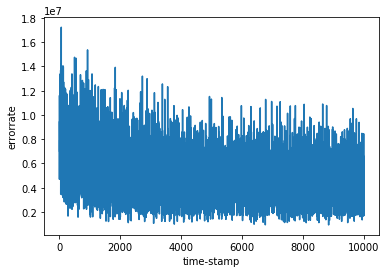

In [7]:
my_matrix = np.loadtxt(open('errorrate.csv',"rb"),delimiter=",",skiprows=0)
plt.plot(my_matrix[0])
plt.xlabel('time-stamp')
plt.ylabel('errorrate')

In [3]:
haha0 = librosa.load('dataset/train/ikala/abjones_1_03.wav', sr = 16000, mono=False)
print('direct loaded data:')
print(haha0)
print(np.mean(haha0[0][1]))
print(np.max(haha0[0][1]))
print(np.min(haha0[0][1]))
haha = _pad_wav(librosa.load('dataset/train/ikala/abjones_1_03.wav', sr = 16000, mono=False)[0],16000,8.192)
print(haha.shape)
haha = to_spectrogram(haha);
print('In spectrum form:')
print(haha.shape)
temp = np.squeeze(haha[1])

print(temp)
print(np.mean(sum(sum(temp))))
print(np.max(temp))
print(np.min(temp))

#提取了1维的内容
haha = haha[1,:,:]
haha = haha[np.newaxis,:,:]
haha = to_wav_from_spec(haha)
print(haha)
print(np.mean(haha0[0][1]))
print(np.max(haha0[0][1]))
print(np.min(haha0[0][1]))
haha = np.squeeze(haha)
print('difference between replaced and original sound')
haha = haha0[0][1]-haha[0:114177]
print(haha)
print(np.mean(haha0[0][1]))
print(np.max(haha0[0][1]))
print(np.min(haha0[0][1]))
librosa.output.write_wav('testing.wav', haha, 22050)

direct loaded data:
(array([[-0.01565552, -0.01461792, -0.01071167, ...,  0.00323486,
        -0.00027466, -0.00140381],
       [ 0.00033569,  0.        , -0.00048828, ...,  0.00048828,
        -0.00204468, -0.00253296]], dtype=float32), 16000)
0.00011409352
0.4961853
-0.44973755
(2, 131072)
In spectrum form:
(2, 513, 513)
[[-4.7116694e-01+0.0000000e+00j -4.6395144e-01+0.0000000e+00j
  -6.5111274e-01+0.0000000e+00j ...  0.0000000e+00+0.0000000e+00j
   0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j]
 [ 2.1697406e-01+9.7578196e-19j  2.2411314e-01+1.9295413e-02j
   2.9057652e-01-2.0339881e-01j ...  0.0000000e+00+0.0000000e+00j
   0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j]
 [ 1.0903644e-01+3.4152368e-18j -8.4128462e-02-1.1404621e-01j
   8.6127743e-02+2.4426898e-01j ...  0.0000000e+00-0.0000000e+00j
   0.0000000e+00-0.0000000e+00j  0.0000000e+00-0.0000000e+00j]
 ...
 [-5.3930178e-04-3.4152368e-18j  3.1252170e-04+6.3582446e-04j
  -1.8401776e-04-2.8828124e-04j ...

In [6]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.
